In [228]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et

# Georgia

## Election Results Documentation:

Election results from the Georgia Secretary of State Elections Division (https://sos.ga.gov/index.php/Elections/current_and_past_elections_results). Presidential recount results from the Georgia Secretary of State Elections Division via Reuters.

## Shapefile Source Documentation:

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office (http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx).  

The following counties instead use shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release: Cobb, DeKalb, Gwinnett. Forsyth and Fulton use shapefiles sourced from the respective counties.

## Shapefile Modifications Documentation:

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

The following additional modifications reflect changes made prior to the 2020 general election:

Barrow: Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary
Bartow: Split Cassville/Hamilton Crossing
Candler: Merge Candler/Metter as Jack Strickland Comm Center
Chatham: Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C
Chatooga: Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile
Clayton: Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5 
Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B
Columbia: Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps
Coweta: Merge Arts Centre/Jefferson Parkway as Newnan Centre
Fulton: Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035
DeKalb: Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits 
Gwinnett: Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G
Lowndes: Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU
Oconee: Merge Annex/City Hall; Align City Hall with Watkinsville city limits
Paulding: Reorganize 12 precincts into 19 precincts as redrawn in 2019
Randolph: Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman
Troup: Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps
Towns: Merge Macedonia/Tate City

Note that the leading zeros in the Paulding County precinct IDs are included in some election reports and omitted in others. The shapefile includes the leading zeros consistent with the voter file.

## Candidate List

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
  
C20PRERTRU - Donald J. Trump (Republican Party)  
C20PREDBID - Joseph R. Biden (Democratic Party)  
C20PRELJOR - Jo Jorgensen (Libertarian Party)  
  
G20USSRPER - David A. Perdue (Republican Party)  
G20USSDOSS - Jon Ossoff (Democratic Party)  
G20USSLHAZ - Shane Hazel (Libertarian Party)  
  
S20USSRLOE - Kelly Loeffler (Republican Party)  
S20USSRCOL - Doug Collins (Republican Party)  
S20USSRGRA - Derrick E. Grayson (Republican Party)  
S20USSRJAC - Annette Davis Jackson (Republican Party)  
S20USSRTAY - Kandiss Taylor (Republican Party)  
S20USSRJOH - A. Wayne Johnson (Republican Party)  
S20USSDWAR - Raphael Warnock (Democratic Party)  
S20USSDJAC - Deborah Jackson (Democratic Party)  
S20USSDLIE - Matt Lieberman (Democratic Party)  
S20USSDJOH - Tamara Johnson-Shealey (Democratic Party)  
S20USSDJAM - Jamesia James (Democratic Party)  
S20USSDSLA - Joy Felicia Slade (Democratic Party)  
S20USSDWIN - Richard Dien Winfield (Democratic Party)  
S20USSDTAR - Ed Tarver (Democratic Party)  
S20USSLSLO - Brian Slowinski (Libertarian Party)  
S20USSGFOR - John Fortuin (Green Party)  
S20USSIBUC - Allen Buckley (Independent)  
S20USSIBAR - Al Bartell (Independent)  
S20USSISTO - Valencia Stovall (Independent)  
S20USSIGRE - Michael Todd Greene (Independent)  
  
G20PSCRSHA - Jason Shaw (Republican Party)  
G20PSCDBRY - Robert G. Bryant (Democratic Party)  
G20PSCLMEL - Elizabeth Melton (Libertarian Party)  
  
G20PSCRMCD - Lauren Bubba McDonald, Jr. (Republican Party)  
G20PSCDBLA - Daniel Blackman (Democratic Party)  
G20PSCLWIL - Nathan Wilson (Libertarian Party)  

### Load Non-Recount Election Data

This data had to be downloaded county-by-county in XML format. The below code parses the XML and grabs the necessary data, adds it to a list, gives it the appropriate column names, and converts the data into a dataframe.

In [229]:
loaded_counties = os.listdir("./raw-from-source/Non_Recount_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Non_Recount_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_general = pd.DataFrame(z,columns=dfcols)

#### Take a look at the dataframe

In [230]:
df_general.head(1)

,county,contest,choice,voting_method,precinct,num_votes
0,Crisp,President of the United States,Donald J. Trump (I) (Rep),Election Day Votes,Arabi,163


### Load Recount Election Data

This data had to be downloaded county-by-county in XML format. The below code parses the XML and grabs the necessary data, adds it to a list, gives it the appropriate column names, and converts the data into a dataframe.

In [231]:
loaded_counties = os.listdir("./raw-from-source/Recount_Results/")
z=[]
for locale in loaded_counties:
    if locale.endswith('.xml'):
        file_string = "./raw-from-source/Recount_Results/"+locale
        xtree = et.parse(file_string)
        xroot = xtree.getroot()
        store_list = []
        county_area = xroot.findall(".//Region")
        for i in county_area:
            county = i.text
        contests = xroot.findall(".//Contest")
        for i in contests:
            contest = i.attrib.get('text')
            lower = i.findall("./Choice")
            for j in lower:
                choice = j.attrib.get('text')
                lower_2 = j.findall("./VoteType")
                for k in lower_2:
                    voting_method = k.attrib.get('name')
                    lower_3 = k.findall("./Precinct")
                    for l in lower_3:
                        precinct_name = l.attrib.get('name')
                        num_votes = l.attrib.get('votes')
                        z.append([county,contest,choice,voting_method,precinct_name,num_votes])
dfcols = ['county','contest','choice','voting_method','precinct','num_votes']
df_recount = pd.DataFrame(z,columns=dfcols)

#### Take a look at the dataframe

In [232]:
df_recount.head(2)

,county,contest,choice,voting_method,precinct,num_votes
0,Oconee,President of the United States,Donald J. Trump (I) (Rep),Election Day Votes,City Hall,244
1,Oconee,President of the United States,Donald J. Trump (I) (Rep),Election Day Votes,Colham Ferry,182


### Clean Recount Data - Contest Names

Note: Doing this before combining with the other data so the presidential vote tallies don't get mixed up

In [233]:
print(df_recount["contest"].unique())

contest_changes_dict = {'President of the United States':'President-Recount',
 'President of the United States/Presidentede los Estados Unidos':'President-Recount'}

df_recount["contest"] = df_recount["contest"].map(contest_changes_dict).fillna(df_recount["contest"])

['President of the United States'
 'President of the United States/Presidentede los Estados Unidos']


### Join Election Data Together

In [234]:
ga_election = pd.concat([df_general,df_recount])

#Sanity check that there are the right number of counties, should be 159
print(len(ga_election["county"].unique()))

159


### Filter Down to Relevant Races

In [235]:
office_list = ['President of the United States','US Senate (Perdue)','US Senate (Loeffler) - Special',
              'Public Service Commission District 1','Public Service Commission District 4',
              'US Senate (Loeffler) - Special Election','President-Recount','President of the United States/Presidentede los Estados Unidos',
              'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1',
       'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4','US Senate (Perdue)/Senado de los EE.UU. (Perdue)',
       'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial',]

ga_election = ga_election[ga_election["contest"].isin(office_list)]

### Clean and Pivot Data

In [236]:
print(ga_election["contest"].unique())

['President of the United States' 'US Senate (Perdue)'
 'US Senate (Loeffler) - Special' 'Public Service Commission District 1'
 'Public Service Commission District 4'
 'US Senate (Loeffler) - Special Election'
 'President of the United States/Presidentede los Estados Unidos'
 'US Senate (Perdue)/Senado de los EE.UU. (Perdue)'
 'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial'
 'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1'
 'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4'
 'President-Recount']


In [237]:
contest_changes_dict = {'US Senate (Loeffler) - Special Election':'US Senate (Loeffler) - Special',
                        'US Senate (Loeffler) - Special/Senado de los EE.UU. (Loeffler) - Especial':'US Senate (Loeffler) - Special',
                        'US Senate (Perdue)/Senado de los EE.UU. (Perdue)':'US Senate (Perdue)',
                        'President of the United States/Presidentede los Estados Unidos':'President of the United States',
                        'Public Service Commission Dist 1/Comisionado de Servicio Público Dist 1':'Public Service Commission District 1',
                        'Public Service Commission Dist 4/Comisionado de Servicio Público Dist 4':'Public Service Commission District 4'}

ga_election["contest"] = ga_election["contest"].map(contest_changes_dict).fillna(ga_election["contest"])

#### Check remaining contests

In [238]:
print(ga_election["contest"].unique())

['President of the United States' 'US Senate (Perdue)'
 'US Senate (Loeffler) - Special' 'Public Service Commission District 1'
 'Public Service Commission District 4' 'President-Recount']


### Clean Candidate Names

In [239]:
print(ga_election["choice"].unique())

['Donald J. Trump (I) (Rep)' 'Joseph R. Biden (Dem)' 'Jo Jorgensen (Lib)'
 'David A. Perdue (I) (Rep)' 'Jon Ossoff (Dem)' 'Shane Hazel (Lib)'
 'Al Bartell (Ind)' 'Allen Buckley (Ind)' 'Doug Collins (Rep)'
 'John Fortuin (Grn)' 'Derrick E. Grayson (Rep)'
 'Michael Todd Greene (Ind)' 'Annette Davis Jackson (Rep)'
 'Deborah Jackson (Dem)' 'Jamesia James (Dem)' 'A. Wayne Johnson (Rep)'
 'Tamara Johnson-Shealey (Dem)' 'Matt Lieberman (Dem)'
 'Kelly Loeffler (I) (Rep)' 'Joy Felicia Slade (Dem)'
 'Brian Slowinski (Lib)' 'Valencia Stovall (Ind)' 'Ed Tarver (Dem)'
 'Kandiss Taylor (Rep)' 'Raphael Warnock (Dem)'
 'Richard Dien Winfield (Dem)' 'Jason Shaw (I) (Rep)'
 'Robert G. Bryant (Dem)' 'Elizabeth Melton (Lib)'
 'Lauren Bubba McDonald, Jr. (I) (Rep)' 'Daniel Blackman (Dem)'
 'Nathan Wilson (Lib)' 'Matt Lierberman (Dem)']


#### Correct the Candidate Name Typo

In [240]:
cand_change_dict = {'Matt Lierberman (Dem)':'Matt Lieberman (Dem)'}
ga_election["choice"] = ga_election["choice"].map(cand_change_dict).fillna(ga_election["choice"])

In [241]:
ga_election["num_votes"] = ga_election["num_votes"].astype(int)

#### Add a FIPS Column

In [242]:
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Georgia"]
fips_file["FIPS County"] = fips_file["FIPS County"].astype(str)
fips_file["FIPS County"] = fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"] = fips_file["County Name"].replace("De Kalb","DeKalb")
fips_dict = dict(zip(fips_file['County Name'], fips_file['FIPS County']))
ga_election['county_fips'] = ga_election['county'].map(fips_dict).fillna(ga_election['county'])
ga_election['county_fips'] = ga_election['county_fips'].astype(str)
ga_election['county_fips'] = ga_election['county_fips'].str.zfill(3)

#### Pivot the data

In [243]:
ga_election["unique_ID"]=ga_election["county_fips"]+ga_election["precinct"]
ga_election["choice"]=ga_election["choice"]+ga_election["contest"]
ga_election=pd.pivot_table(ga_election,index=["unique_ID","county","county_fips","precinct"],columns=["choice"],values=['num_votes'],aggfunc=sum)
ga_election = ga_election.fillna(0)
ga_election.columns = ga_election.columns.droplevel(0)
ga_election = ga_election.reset_index()

#### Change Names to match VEST

In [244]:
column_changes_dict = {'A. Wayne Johnson (Rep)US Senate (Loeffler) - Special':'S20USSRJOH',
       'Al Bartell (Ind)US Senate (Loeffler) - Special':'S20USSIBAR',
       'Allen Buckley (Ind)US Senate (Loeffler) - Special':'S20USSIBUC',
       'Annette Davis Jackson (Rep)US Senate (Loeffler) - Special':'S20USSRJAC',
       'Brian Slowinski (Lib)US Senate (Loeffler) - Special':'S20USSLSLO',
       'Daniel Blackman (Dem)Public Service Commission District 4':'G20PSCDBLA',
       'David A. Perdue (I) (Rep)US Senate (Perdue)':'G20USSRPER',
       'Deborah Jackson (Dem)US Senate (Loeffler) - Special':'S20USSDJAC',
       'Derrick E. Grayson (Rep)US Senate (Loeffler) - Special':'S20USSRGRA',
       'Donald J. Trump (I) (Rep)President of the United States':'G20PRERTRU',
       'Donald J. Trump (I) (Rep)President-Recount':'C20PRERTRU',
       'Doug Collins (Rep)US Senate (Loeffler) - Special':'S20USSRCOL',
       'Ed Tarver (Dem)US Senate (Loeffler) - Special':'S20USSDTAR',
       'Elizabeth Melton (Lib)Public Service Commission District 1':'G20PSCLMEL',
       'Jamesia James (Dem)US Senate (Loeffler) - Special':'S20USSDJAM',
       'Jason Shaw (I) (Rep)Public Service Commission District 1':'G20PSCRSHA',
       'Jo Jorgensen (Lib)President of the United States':'G20PRELJOR',
       'Jo Jorgensen (Lib)President-Recount':'C20PRELJOR',
       'John Fortuin (Grn)US Senate (Loeffler) - Special':'S20USSGFOR',
       'Jon Ossoff (Dem)US Senate (Perdue)':'G20USSDOSS',
       'Joseph R. Biden (Dem)President of the United States':'G20PREDBID',
       'Joseph R. Biden (Dem)President-Recount':'C20PREDBID',
       'Joy Felicia Slade (Dem)US Senate (Loeffler) - Special':'S20USSDSLA',
       'Kandiss Taylor (Rep)US Senate (Loeffler) - Special':'S20USSRTAY',
       'Kelly Loeffler (I) (Rep)US Senate (Loeffler) - Special':'S20USSRLOE',
       'Lauren Bubba McDonald, Jr. (I) (Rep)Public Service Commission District 4':'G20PSCRMCD',
       'Matt Lieberman (Dem)US Senate (Loeffler) - Special':'S20USSDLIE',
       'Michael Todd Greene (Ind)US Senate (Loeffler) - Special':'S20USSIGRE',
       'Nathan Wilson (Lib)Public Service Commission District 4':'G20PSCLWIL',
       'Raphael Warnock (Dem)US Senate (Loeffler) - Special':'S20USSDWAR',
       'Richard Dien Winfield (Dem)US Senate (Loeffler) - Special':'S20USSDWIN',
       'Robert G. Bryant (Dem)Public Service Commission District 1':'G20PSCDBRY',
       'Shane Hazel (Lib)US Senate (Perdue)':'G20USSLHAZ',
       'Tamara Johnson-Shealey (Dem)US Senate (Loeffler) - Special':'S20USSDJOH',
       'Valencia Stovall (Ind)US Senate (Loeffler) - Special':'S20USSISTO'}

ga_election = ga_election.rename(columns=column_changes_dict)

#### Order election result columns to match VEST

In [245]:
ga_election = ga_election[['unique_ID', 'county', 'county_fips', 'precinct','G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL']]

### Load the VEST file

In [246]:
vest_ga_20 = gp.read_file("./raw-from-source/VEST/ga_2020/ga_2020.shp")

#### Take a look

In [247]:
vest_ga_20.head(1)

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,S20USSIBAR,S20USSISTO,S20USSIGRE,G20PSCRSHA,G20PSCDBRY,G20PSCLMEL,G20PSCRMCD,G20PSCDBLA,G20PSCLWIL,geometry
0,215122,215122,122,FIRST AFRICAN,MUSCOGEE,106,106,215,238,668,...,9,1,4,251,587,52,251,587,44,"POLYGON ((-84.96984 32.46725, -84.97031 32.467..."


In [248]:
data_columns = ['G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL']

for race in data_columns:
    ga_election[race] = ga_election[race].astype(int)

### Compare Statewide Candidate Totals

In [249]:
no_diff = True
for race in data_columns:
    #Un-comment the below to visually check results against official state counts: https://results.enr.clarityelections.com/GA/105369/web.264614/#/summary
    #print(race+": "+str(sum(ga_election[race])))
    if (sum(vest_ga_20[race])-sum(ga_election[race]) != 0):
        print(race+" has a difference of "+str(sum(vest_ga_20[race])-sum(ga_election[race]))+" votes")
        print("\tVEST: "+str(sum(vest_ga_20[race]))+" votes")
        print("\tSOURCES: "+str(sum(ga_election[race]))+" votes")
        no_diff = False
if (no_diff):
    print("No races contain vote differences")
else:
    print("All other races are equal")

No races contain vote differences


### Compare Countywide Candidate Totals

In [250]:
no_diff = True
diff_counties=[]
for i in data_columns:
    diff = vest_ga_20.groupby(["FIPS2"]).sum()[i]-ga_election.groupby(["county_fips"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
        no_diff = False
if (no_diff):
    print("No counties contain vote differences")
else:
    print("All other county race totals are equal")

No counties contain vote differences


### Join Election Results to VEST (to eventually validate precinct votes)

#### Try a  unique ID

In [251]:
ga_election["precinct"] = ga_election["precinct"].str.strip().str.upper()
ga_election["unique_ID"]=ga_election["county_fips"]+"-"+ga_election["precinct"]
vest_ga_20["unique_ID"]=vest_ga_20["FIPS2"]+"-"+vest_ga_20["PRECINCT_N"]

#### Check whether there are duplicate IDs

In [252]:
ser = ga_election["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

ser = vest_ga_20["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

Series([], Name: unique_ID, dtype: int64)
NaN                        7
051-ELI WHITNEY COMPLEX    2
Name: unique_ID, dtype: int64


In [253]:
#Look into duplicate IDs - ELI WHITNEY
display(vest_ga_20[vest_ga_20["unique_ID"]=="051-ELI WHITNEY COMPLEX"])

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,S20USSISTO,S20USSIGRE,G20PSCRSHA,G20PSCDBRY,G20PSCLMEL,G20PSCRMCD,G20PSCDBLA,G20PSCLWIL,geometry,unique_ID
2245,0513-15C,0513-15C,3-15C,ELI WHITNEY COMPLEX,CHATHAM,25,025,051,278,361,...,0,1,301,320,16,290,325,15,"POLYGON ((-81.02948 32.06200, -81.03000 32.060...",051-ELI WHITNEY COMPLEX
2247,0512-06C,0512-06C,2-06C,ELI WHITNEY COMPLEX,CHATHAM,25,025,051,65,335,...,2,1,72,294,25,67,301,19,"POLYGON ((-81.05333 32.07291, -81.05336 32.072...",051-ELI WHITNEY COMPLEX


In [254]:
#Assign new unique IDs, adding in PRECINCT_I to differentiate
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0513-15C","unique_ID"] = "051-ELI WHITNEY COMPLEX 3-15C"
vest_ga_20.loc[vest_ga_20["CTYSOSID"]=="0512-06C","unique_ID"] = "051-ELI WHITNEY COMPLEX 2-06C"

In [255]:
display(vest_ga_20[vest_ga_20["unique_ID"].isna()])

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,S20USSISTO,S20USSIGRE,G20PSCRSHA,G20PSCDBRY,G20PSCLMEL,G20PSCRMCD,G20PSCDBLA,G20PSCLWIL,geometry,unique_ID
1329,051XFTPU,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-80.96828 32.04402, -80.96876 32.044...",NaN
1447,029FTSTEW,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-81.59263 32.10346, -81.59242 ...",NaN
2125,215FTBEN2,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.93473 32.40556, -84.93448 32.405...",NaN
2128,215FTBEN4,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.91564 32.42299, -84.90945 32.422...",NaN
2146,215FTBEN3,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.93783 32.40666, -84.93765 32.406...",NaN
2229,215ZZZZZZ,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.89892 32.45201, -84.89890 32.452...",NaN
2230,215FTBEN1,None,None,None,None,None,None,None,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.89897 32.44577, -84.89896 32.449...",NaN


In [256]:
vest_ga_20.loc[vest_ga_20['unique_ID'].isna(), 'unique_ID'] = vest_ga_20['DISTRICT']

#### Confirm there are no duplicate IDs

In [257]:
ser = ga_election["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

ser = vest_ga_20["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

Series([], Name: unique_ID, dtype: int64)
Series([], Name: unique_ID, dtype: int64)


In [258]:
join_attempt_1 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_1["_merge"].value_counts())

both          2545
right_only     134
left_only      111
Name: _merge, dtype: int64


In [259]:
left_only = join_attempt_1[join_attempt_1["_merge"]=="left_only"]
right_only = join_attempt_1[join_attempt_1["_merge"]=="right_only"]



In [260]:
example_csv = pd.read_csv("./source_vest_id_changes.csv")
example_fips_dict = dict(zip(example_csv["source_ID"],example_csv["vest_ID"]))

In [261]:
ga_election["unique_ID"] = ga_election["unique_ID"].map(example_fips_dict).fillna(ga_election["unique_ID"])

In [262]:
join_attempt_2 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_2["_merge"].value_counts())

both = join_attempt_2[join_attempt_2["_merge"]=="both"]
left_only = join_attempt_2[join_attempt_2["_merge"]=="left_only"]
right_only = join_attempt_2[join_attempt_2["_merge"]=="right_only"]

left_only.to_csv("./source_only.csv")
right_only.to_csv("./VEST_only.csv")

both          2656
right_only      23
left_only        0
Name: _merge, dtype: int64


In [263]:
empty_precincts = []
for index, row in right_only.iterrows():
    for race in data_columns:
        keep=True
        if (row[race+"_y"]!=0):
            keep = False
    if(keep):
        empty_precincts.append(row["DISTRICT"])
print(len(empty_precincts))  

23


In [264]:
print(empty_precincts)

['121AP01E', '121UC033', '12103P1B', '121AP12D', '121SC29B', '121CP06B', '121CP053', '121SC07B', '121RW22B', '121SC08A', '121SC21A', '121UC01C', '121CP052', '051XFTPU', '029FTSTEW', '121RW11B', '12108F2', '12112E2', '215FTBEN2', '215FTBEN4', '215FTBEN3', '215ZZZZZZ', '215FTBEN1']


In [265]:
vest_ga_20[vest_ga_20["DISTRICT"].isin(empty_precincts)]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,S20USSISTO,S20USSIGRE,G20PSCRSHA,G20PSCDBRY,G20PSCLMEL,G20PSCRMCD,G20PSCDBLA,G20PSCLWIL,geometry,unique_ID
249,121AP01E,121AP01E,AP01E,AP01E,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.29795 34.03893, -84.29797 34.037...",121-AP01E
250,121UC033,121UC033,UC033,UC033,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-84.50565 33.58889, -84.50668 ...",121-UC033
679,12103P1B,12103P1B,03P1B,03P1B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.40813 33.77318, -84.40764 33.773...",121-03P1B
688,121AP12D,121AP12D,AP12D,AP12D,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.25836 34.09181, -84.25818 34.091...",121-AP12D
887,121SC29B,121SC29B,SC29B,SC29B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.51576 33.58520, -84.51580 33.585...",121-SC29B
935,121CP06B,121CP06B,CP06B,CP06B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.46700 33.62007, -84.47102 33.620...",121-CP06B
951,121CP053,121CP053,CP053,CP053,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.48197 33.62309, -84.48200 33.623...",121-CP053
955,121SC07B,121SC07B,SC07B,SC07B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.58213 33.62434, -84.58229 33.624...",121-SC07B
966,121RW22B,121RW22B,RW22B,RW22B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.27466 33.99256, -84.27435 33.992...",121-RW22B
999,121SC08A,121SC08A,SC08A,SC08A,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.55685 33.60644, -84.55673 33.606...",121-SC08A


In [266]:
empty_unjoined = vest_ga_20[vest_ga_20["DISTRICT"].isin(empty_precincts)]

In [267]:
display(empty_unjoined)

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER,CTYNUMBER2,FIPS2,G20PRERTRU,G20PREDBID,...,S20USSISTO,S20USSIGRE,G20PSCRSHA,G20PSCDBRY,G20PSCLMEL,G20PSCRMCD,G20PSCDBLA,G20PSCLWIL,geometry,unique_ID
249,121AP01E,121AP01E,AP01E,AP01E,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.29795 34.03893, -84.29797 34.037...",121-AP01E
250,121UC033,121UC033,UC033,UC033,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"MULTIPOLYGON (((-84.50565 33.58889, -84.50668 ...",121-UC033
679,12103P1B,12103P1B,03P1B,03P1B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.40813 33.77318, -84.40764 33.773...",121-03P1B
688,121AP12D,121AP12D,AP12D,AP12D,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.25836 34.09181, -84.25818 34.091...",121-AP12D
887,121SC29B,121SC29B,SC29B,SC29B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.51576 33.58520, -84.51580 33.585...",121-SC29B
935,121CP06B,121CP06B,CP06B,CP06B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.46700 33.62007, -84.47102 33.620...",121-CP06B
951,121CP053,121CP053,CP053,CP053,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.48197 33.62309, -84.48200 33.623...",121-CP053
955,121SC07B,121SC07B,SC07B,SC07B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.58213 33.62434, -84.58229 33.624...",121-SC07B
966,121RW22B,121RW22B,RW22B,RW22B,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.27466 33.99256, -84.27435 33.992...",121-RW22B
999,121SC08A,121SC08A,SC08A,SC08A,FULTON,60,060,121,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-84.55685 33.60644, -84.55673 33.606...",121-SC08A


In [268]:
empty_unjoined = empty_unjoined[["unique_ID","CTYNAME","FIPS2","PRECINCT_N",'S20USSRJOH',
       'S20USSIBAR', 'S20USSIBUC', 'S20USSRJAC', 'S20USSLSLO', 'G20PSCDBLA',
       'G20USSRPER', 'S20USSDJAC', 'S20USSRGRA', 'G20PRERTRU', 'C20PRERTRU',
       'S20USSRCOL', 'S20USSDTAR', 'G20PSCLMEL', 'S20USSDJAM', 'G20PSCRSHA',
       'G20PRELJOR', 'C20PRELJOR', 'S20USSGFOR', 'G20USSDOSS', 'G20PREDBID',
       'C20PREDBID', 'S20USSDSLA', 'S20USSRTAY', 'S20USSRLOE', 'G20PSCRMCD',
       'S20USSDLIE', 'S20USSIGRE', 'G20PSCLWIL', 'S20USSDWAR', 'S20USSDWIN',
       'G20PSCDBRY', 'G20USSLHAZ', 'S20USSDJOH', 'S20USSISTO']]

empty_unjoined.columns = ga_election.columns



In [269]:
print(empty_unjoined.columns)
print(ga_election.columns)

Index(['unique_ID', 'county', 'county_fips', 'precinct', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR',
       'G20USSRPER', 'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL',
       'S20USSRGRA', 'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR',
       'S20USSDJAC', 'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA',
       'S20USSDWIN', 'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC',
       'S20USSIBAR', 'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY',
       'G20PSCLMEL', 'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL'],
      dtype='object', name='choice')
Index(['unique_ID', 'county', 'county_fips', 'precinct', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR',
       'G20USSRPER', 'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL',
       'S20USSRGRA', 'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR',
       'S20USSDJAC', 'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', '

In [270]:
empty_unjoined.columns = ga_election.columns

In [277]:
display(empty_unjoined)

choice,unique_ID,county,county_fips,precinct,G20PRERTRU,G20PREDBID,G20PRELJOR,C20PRERTRU,C20PREDBID,C20PRELJOR,...,S20USSIBUC,S20USSIBAR,S20USSISTO,S20USSIGRE,G20PSCRSHA,G20PSCDBRY,G20PSCLMEL,G20PSCRMCD,G20PSCDBLA,G20PSCLWIL
249,121-AP01E,FULTON,121,AP01E,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
250,121-UC033,FULTON,121,UC033,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
679,121-03P1B,FULTON,121,03P1B,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
688,121-AP12D,FULTON,121,AP12D,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
887,121-SC29B,FULTON,121,SC29B,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
935,121-CP06B,FULTON,121,CP06B,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
951,121-CP053,FULTON,121,CP053,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
955,121-SC07B,FULTON,121,SC07B,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,121-RW22B,FULTON,121,RW22B,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999,121-SC08A,FULTON,121,SC08A,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [272]:
ga_election = pd.concat([ga_election,empty_unjoined])

In [273]:
print(vest_ga_20.loc[vest_ga_20['unique_ID'].isna()])
vest_ga_20.loc[vest_ga_20['unique_ID'].isna(), 'unique_ID'] = vest_ga_20['DISTRICT']
print(vest_ga_20.loc[vest_ga_20['unique_ID'].isna()])

Empty GeoDataFrame
Columns: [DISTRICT, CTYSOSID, PRECINCT_I, PRECINCT_N, CTYNAME, CTYNUMBER, CTYNUMBER2, FIPS2, G20PRERTRU, G20PREDBID, G20PRELJOR, C20PRERTRU, C20PREDBID, C20PRELJOR, G20USSRPER, G20USSDOSS, G20USSLHAZ, S20USSRLOE, S20USSRCOL, S20USSRGRA, S20USSRJAC, S20USSRTAY, S20USSRJOH, S20USSDWAR, S20USSDJAC, S20USSDLIE, S20USSDJOH, S20USSDJAM, S20USSDSLA, S20USSDWIN, S20USSDTAR, S20USSLSLO, S20USSGFOR, S20USSIBUC, S20USSIBAR, S20USSISTO, S20USSIGRE, G20PSCRSHA, G20PSCDBRY, G20PSCLMEL, G20PSCRMCD, G20PSCDBLA, G20PSCLWIL, geometry, unique_ID]
Index: []

[0 rows x 45 columns]
Empty GeoDataFrame
Columns: [DISTRICT, CTYSOSID, PRECINCT_I, PRECINCT_N, CTYNAME, CTYNUMBER, CTYNUMBER2, FIPS2, G20PRERTRU, G20PREDBID, G20PRELJOR, C20PRERTRU, C20PREDBID, C20PRELJOR, G20USSRPER, G20USSDOSS, G20USSLHAZ, S20USSRLOE, S20USSRCOL, S20USSRGRA, S20USSRJAC, S20USSRTAY, S20USSRJOH, S20USSDWAR, S20USSDJAC, S20USSDLIE, S20USSDJOH, S20USSDJAM, S20USSDSLA, S20USSDWIN, S20USSDTAR, S20USSLSLO, S20USSGFOR, S2

In [274]:
join_attempt_2 = pd.merge(ga_election,vest_ga_20,how="outer",on="unique_ID",indicator=True)
print(join_attempt_2["_merge"].value_counts())

#Code below was used during processing
#both = join_attempt_2[join_attempt_2["_merge"]=="both"]
#left_only = join_attempt_2[join_attempt_2["_merge"]=="left_only"]
#right_only = join_attempt_2[join_attempt_2["_merge"]=="right_only"]
#left_only.to_csv("./source_only.csv")
#right_only.to_csv("./VEST_only.csv")

both          2679
left_only        0
right_only       0
Name: _merge, dtype: int64


### Validate election results precinct-by-precinct

In [276]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff >0):
                if(diff>0):
                    print(i, "{:.>72}".format(df.iloc[j]["final_join_col"]), "(S)","{:.>5}".format(int(df.iloc[j][left_Data]))," (V){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]["final_join_col"])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]["final_join_col"])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)
    
validater_row(both,data_columns)


There are  2679  total rows
0  of these rows have election result differences
2679  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10
[]


## Shapefiles 

### Shapefile Sources

Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office (http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx).  

The following counties instead use shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release: Cobb, DeKalb, Gwinnett. Forsyth and Fulton use shapefiles sourced from the respective counties.

### 1. Load Primary Precinct Shapefile

In [353]:
#Load in file
shapefiles_state = gp.read_file("./raw-from-source/Shapefiles/vtd2020-shape-4-20-21/VTD2020-Shape.shp")

In [359]:
print(shapefiles_state[shapefiles_state["CTYNAME"]=="COBB"]["PRECINCT_N"].unique())

#### Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B - Not Completed

['WILLEO 01' 'VININGS 01' 'TERRELL MILL 01' 'SOPE CREEK 02'
 'SOPE CREEK 03' 'ROSWELL 01' 'MT BETHEL 01' 'TIMBER RIDGE 01'
 'MT BETHEL 03' 'FULLERS PARK 01' 'SEWELL MILL 01' 'MURDOCK 01'
 'MT BETHEL 04' 'EASTSIDE 01' 'DODGEN 01' 'CHESTNUT RIDGE 01' 'ROSWELL 02'
 'LOST MOUNTAIN 02' 'FORD 01' 'DURHAM 01' 'KEMP 03' 'FREY 01'
 'LOST MOUNTAIN 04' 'MARS HILL 01' 'KENNESAW 1A' 'BIG SHANTY 01'
 'WADE GREEN 02' 'BIG SHANTY 02' 'MCEACHERN 01' 'LOST MOUNTAIN 01'
 'OREGON 01' 'VAUGHAN 01' 'DICKERSON 01' 'SANDY PLAINS 01' 'POPE 01'
 'MABRY 01' 'DAVIS 01' 'GARRISON MILL 01' 'POST OAK 01' 'HIGHTOWER 01'
 'SHALLOWFORD FALLS 01' 'MCCLURE 01' 'ACWORTH 1A' 'HARMONY-LELAND 01'
 'LINDLEY 01' 'ACWORTH 1B' 'AUSTELL 1A' 'CLARKDALE 01' 'POWDER SPRINGS 2A'
 'COOPER 01' 'OREGON 02' 'CLARKDALE 02' 'MABLETON 02' 'BRYANT 02'
 'RIVERSIDE 01' 'POWDER SPRINGS 1A' 'POWDER SPRINGS 3A' 'LOST MOUNTAIN 03'
 'BIRNEY 02' 'BIRNEY 01' 'MABLETON 03' 'MABLETON 04' 'HARRISON 01'
 'KEMP 01' 'HAYES 01' 'PINE MOUNTAIN 02' 'SMYRNA 7A

#### Filter out Cobb, Gwinnett, DeKalb, Fulton and Forsyth

In [301]:
#Make a copy of just Fulton (found that this was closer to VEST's final file)
filtered_fulton = shapefiles_state[shapefiles_state["FIPS2"]=="121"]

#Cobb, Gwinnett and DeKalb
"13135","13067","13089"

#Fulton and Forsyth
"13121","13117"

filter_list = ["135","067","089","121","117"]

shapefiles_state = shapefiles_state[~shapefiles_state["FIPS2"].isin(filter_list)]

### 2. Load Census Redistricting Phase 2 Data

In [302]:
#When downloading from the Census redistricing data program, counties are identified via a FIPS code
fips_codes = ["13135","13067","13089"]

#Combine all the data from separate files into one
li = []
for i in fips_codes:
    ref = "./raw-from-source/Shapefiles/Census/partnership_shapefiles_19v2_"
    file_ref = ref+i+"/PVS_19_v2_vtd_"+i+".shp"
    file_prev = gp.read_file(file_ref)
    #print(file_prev.shape)
    li.append(file_prev)
shapefiles_census = pd.concat(li, axis=0, ignore_index=True)

### 3. Shapefile data from the counties themselves

In [303]:
shapefiles_fulton = gp.read_file("./raw-from-source/Shapefiles/Fulton/Voting_Precincts/Voting_Precincts.shp")

shapefiles_forsyth  = gp.read_file("./raw-from-source/Shapefiles/Forsyth/Voting_Precinct-shp/Voting_Precinct.shp")

epsg:4019


<AxesSubplot:>

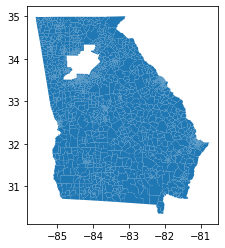

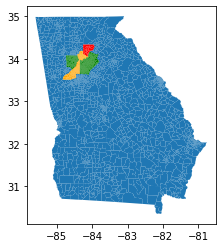

In [304]:
print(vest_ga_20.crs)

shapefiles_forsyth = shapefiles_forsyth.to_crs(4019)
shapefiles_fulton = shapefiles_fulton.to_crs(4019)
shapefiles_census = shapefiles_census.to_crs(4019)

shapefiles_state.plot()

ax = shapefiles_state.plot()
shapefiles_forsyth.plot(ax = ax,color="red")
shapefiles_fulton.plot(ax = ax,color="orange")
shapefiles_census.plot(ax = ax,color="green")

In [305]:
print(shapefiles_state.columns)
print(shapefiles_forsyth.columns)
print(shapefiles_fulton.columns)
print(shapefiles_census.columns)

Index(['ID', 'AREA', 'DATA', 'DISTRICT', 'CTYSOSID', 'PRECINCT_I',
       'PRECINCT_N', 'CNTY', 'FIPS2', 'CTYNAME',
       ...
       'UKNMALEREG', 'UKNMALEVOT', 'UNKMALEVOT', 'UKNFMREG20', 'UKNFMVOTED',
       'UKNFMVOTE1', 'UKNOWNREG2', 'UKNOWNVOTE', 'UKNOWVOTED', 'geometry'],
      dtype='object', length=116)
Index(['OBJECTID', 'PRECINCTID', 'NAME', 'COUNTY', 'Shape__Are', 'Shape__Len',
       'geometry'],
      dtype='object')
Index(['OBJECTID', 'ProposalNo', 'Status', 'RetireStat', 'VoterDist',
       'TurnOut', 'ActVoters', 'FeatureID', 'FacilityID', 'PrecinctN',
       'ShapeSTAre', 'ShapeSTLen', 'geometry'],
      dtype='object')
Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAMELSAD', 'VTDI', 'LSAD', 'CHNG_TYPE',
       'ORIG_NAME', 'ORIG_CODE', 'RELATE', 'NAME', 'VINTAGE', 'FUNCSTAT',
       'JUSTIFY', 'MTFCC', 'geometry'],
      dtype='object')


In [306]:
display(shapefiles_state.head())

,ID,AREA,DATA,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CNTY,FIPS2,CTYNAME,...,UKNMALEREG,UKNMALEVOT,UNKMALEVOT,UKNFMREG20,UKNFMVOTED,UKNFMVOTE1,UKNOWNREG2,UKNOWNVOTE,UKNOWVOTED,geometry
0,1,3.383541,687,073131,073131,131,JOURNEY COMM. CHURCH,036,073,COLUMBIA,...,40.0,25.0,62.500000,42.0,25.0,59.520000,0.0,0.0,0.0,"POLYGON ((-82.16046 33.55708, -82.16080 33.557..."
1,2,1.636596,667,073064,073064,064,GRACE BAPTIST CHURCH,036,073,COLUMBIA,...,167.0,86.0,51.500000,162.0,100.0,61.730000,0.0,0.0,0.0,"POLYGON ((-82.17048 33.57388, -82.18294 33.575..."
2,3,5.598643,664,073061,073061,061,GREENBRIER HIGH,036,073,COLUMBIA,...,158.0,92.0,58.230000,169.0,99.0,58.580002,4.0,3.0,75.0,"POLYGON ((-82.16457 33.61024, -82.16454 33.610..."
3,4,0.872412,666,073063,073063,063,RIVERVIEW CHURCH,036,073,COLUMBIA,...,43.0,33.0,76.739998,47.0,33.0,70.209999,1.0,1.0,100.0,"POLYGON ((-82.13899 33.58584, -82.13881 33.585..."
4,5,2.609909,688,073132,073132,132,WESLEY METHODIST,036,073,COLUMBIA,...,94.0,59.0,62.770000,112.0,72.0,64.290001,1.0,0.0,0.0,"POLYGON ((-82.10224 33.56561, -82.10230 33.565..."


In [307]:
shapefiles_state = shapefiles_state[['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CNTY','CTYNAME','FIPS2','geometry']]
filtered_fulton = filtered_fulton[['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CNTY','CTYNAME','FIPS2','geometry']]
shapefiles_forsyth = shapefiles_forsyth[["PRECINCTID","NAME","COUNTY","geometry"]]
shapefiles_fulton = shapefiles_fulton[["OBJECTID","VoterDist","geometry"]]
shapefiles_census = shapefiles_census[["STATEFP","COUNTYFP","VTDST","NAMELSAD","NAME","geometry"]]

In [308]:
display(vest_ga_20.columns)

shapefile_col_list = ['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME','CTYNUMBER2', 'FIPS2','geometry']

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'C20PRERTRU', 'C20PREDBID', 'C20PRELJOR', 'G20USSRPER',
       'G20USSDOSS', 'G20USSLHAZ', 'S20USSRLOE', 'S20USSRCOL', 'S20USSRGRA',
       'S20USSRJAC', 'S20USSRTAY', 'S20USSRJOH', 'S20USSDWAR', 'S20USSDJAC',
       'S20USSDLIE', 'S20USSDJOH', 'S20USSDJAM', 'S20USSDSLA', 'S20USSDWIN',
       'S20USSDTAR', 'S20USSLSLO', 'S20USSGFOR', 'S20USSIBUC', 'S20USSIBAR',
       'S20USSISTO', 'S20USSIGRE', 'G20PSCRSHA', 'G20PSCDBRY', 'G20PSCLMEL',
       'G20PSCRMCD', 'G20PSCDBLA', 'G20PSCLWIL', 'geometry', 'unique_ID'],
      dtype='object')

In [309]:
shapefiles_state.loc[:,"CTYNUMBER2"] = shapefiles_state.loc[:,"CNTY"]

shapefiles_state = shapefiles_state[shapefile_col_list]

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [310]:
print(shapefiles_forsyth.head())

shapefiles_forsyth.loc[:,"DISTRICT"] = "117"+ shapefiles_forsyth.loc[:,"PRECINCTID"]
shapefiles_forsyth.loc[:,"CTYSOSID"] = shapefiles_forsyth.loc[:,"DISTRICT"]
shapefiles_forsyth.loc[:,"PRECINCT_I"] = shapefiles_forsyth.loc[:,"PRECINCTID"]
shapefiles_forsyth.loc[:,"PRECINCT_N"] = shapefiles_forsyth.loc[:,"PRECINCTID"] + " " + shapefiles_forsyth.loc[:,"NAME"]
shapefiles_forsyth.loc[:,"CTYNAME"] = "FORSYTH"
shapefiles_forsyth.loc[:,"CTYNUMBER2"] = "058"
shapefiles_forsyth.loc[:,"FIPS2"] = "117"

shapefiles_forsyth = shapefiles_forsyth[shapefile_col_list]

  PRECINCTID           NAME   COUNTY  \
0         27        CONCORD  Forsyth   
1         06     CROSSROADS  Forsyth   
2         04      CHESTATEE  Forsyth   
3         03  BROWNS BRIDGE  Forsyth   
4         05  COAL MOUNTAIN  Forsyth   

                                            geometry  
0  POLYGON ((-84.16395 34.29828, -84.16402 34.298...  
1  POLYGON ((-83.97539 34.30389, -83.97550 34.303...  
2  POLYGON ((-83.94688 34.30902, -83.94620 34.308...  
3  POLYGON ((-84.09370 34.25201, -84.09327 34.252...  
4  POLYGON ((-84.07448 34.29508, -84.07471 34.292...  


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [311]:
shapefiles_fulton.head()

shapefiles_fulton.loc[:,"DISTRICT"] = "121"+ shapefiles_fulton.loc[:,"VoterDist"]
shapefiles_fulton.loc[:,"CTYSOSID"] = shapefiles_fulton.loc[:,"DISTRICT"]
shapefiles_fulton.loc[:,"PRECINCT_I"] = shapefiles_fulton.loc[:,"VoterDist"]
shapefiles_fulton.loc[:,"PRECINCT_N"] = shapefiles_fulton.loc[:,"VoterDist"]
shapefiles_fulton.loc[:,"CTYNAME"] = "FULTON"
shapefiles_fulton.loc[:,"CTYNUMBER2"] = "060"
shapefiles_fulton.loc[:,"FIPS2"] = "121"

shapefiles_fulton = shapefiles_fulton[shapefile_col_list]

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [312]:
name_map_dict = {"135":"GWINNETT","067":"COBB","089":"DEKALB"}
num_map_dict = {"135":"067","067":"033","089":"044"}


shapefiles_census.loc[:,"PRECINCT_I"] = shapefiles_census.loc[:,"VTDST"].str[3:]
shapefiles_census.loc[:,"DISTRICT"] = shapefiles_census.loc[:,"COUNTYFP"]+ shapefiles_census.loc[:,"PRECINCT_I"]
shapefiles_census.loc[:,"CTYSOSID"] = shapefiles_census.loc[:,"DISTRICT"]

shapefiles_census.loc[:,"PRECINCT_N"] = shapefiles_census.loc[:,"NAME"]
shapefiles_census.loc[:,"CTYNAME"] = shapefiles_census.loc[:,"COUNTYFP"].map(name_map_dict)
shapefiles_census.loc[:,"CTYNUMBER2"] = shapefiles_census.loc[:,"COUNTYFP"].map(num_map_dict)
shapefiles_census.loc[:,"FIPS2"] = shapefiles_census.loc[:,"COUNTYFP"]

shapefiles_census = shapefiles_census[shapefile_col_list]

In [313]:
ga_shapefile = pd.concat([shapefiles_census,shapefiles_state,shapefiles_fulton,shapefiles_forsyth])
ga_shapefile = pd.concat([shapefiles_census,shapefiles_state,shapefiles_forsyth])
ga_shapefile.reset_index(inplace=True,drop=True)

In [314]:
ga_shapefile["PRECINCT_N"] =ga_shapefile["PRECINCT_N"].str.upper()
ga_shapefile["unique_ID"] = ga_shapefile["FIPS2"]+"-"+ga_shapefile["PRECINCT_N"]

In [315]:
ga_shapefile.loc[ga_shapefile['unique_ID'].isna()]
na_dist_list = ga_shapefile.loc[ga_shapefile['unique_ID'].isna()]["DISTRICT"]

In [316]:
ga_shapefile.loc[(ga_shapefile['unique_ID'].isna())&(ga_shapefile['DISTRICT'].str[0:3]=="121"), 'unique_ID'] = ga_shapefile.loc[:,'DISTRICT'].str[0:3]+"-"+ga_shapefile.loc[:,'DISTRICT'].str[3:]
ga_shapefile.loc[ga_shapefile['unique_ID'].isna(), 'unique_ID'] = ga_shapefile.loc[:,'DISTRICT']

In [317]:
ga_shapefile[ga_shapefile["DISTRICT"].isin(na_dist_list)]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
534,121CH04B,None,None,None,None,None,None,"POLYGON ((-84.66472 33.54058, -84.66442 33.540...",121-CH04B
581,121CP06B,None,None,None,None,None,None,"POLYGON ((-84.47425 33.62469, -84.47392 33.624...",121-CP06B
583,121UC01C,None,None,None,None,None,None,"MULTIPOLYGON (((-84.50531 33.59696, -84.50529 ...",121-UC01C
584,121UC033,None,None,None,None,None,None,"MULTIPOLYGON (((-84.49907 33.59374, -84.49815 ...",121-UC033
585,121SC29B,None,None,None,None,None,None,"POLYGON ((-84.51476 33.58541, -84.51463 33.585...",121-SC29B
586,121UC035,None,None,None,None,None,None,"MULTIPOLYGON (((-84.50786 33.58318, -84.50733 ...",121-UC035
933,215FTBEN2,None,None,None,None,None,None,"POLYGON ((-84.89301 32.40081, -84.89311 32.400...",215FTBEN2
934,215FTBEN4,None,None,None,None,None,None,"POLYGON ((-84.92604 32.42313, -84.92521 32.423...",215FTBEN4
936,215FTBEN1,None,None,None,None,None,None,"POLYGON ((-84.89265 32.40096, -84.89301 32.400...",215FTBEN1
961,053FTBEN3,None,None,None,None,None,None,"POLYGON ((-84.95757 32.31050, -84.95784 32.310...",053FTBEN3


## Shapefile Modifications

### Documentation

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

The following additional modifications reflect changes made prior to the 2020 general election:

**Barrow:** Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary  
**Bartow:** Split Cassville/Hamilton Crossing  
**Candler:** Merge Candler/Metter as Jack Strickland Comm Center  
**Chatham:** Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C  
**Chatooga:** Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile  
**Clayton:** Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5   
**Cobb:** Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B  
**Columbia:** Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps  
**Coweta:** Merge Arts Centre/Jefferson Parkway as Newnan Centre  
**Fulton:** Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035  
**DeKalb:** Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits   
**Gwinnett:** Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G  
**Lowndes:** Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU  
**Oconee:** Merge Annex/City Hall; Align City Hall with Watkinsville city limits  
**Paulding:** Reorganize 12 precincts into 19 precincts as redrawn in 2019  
**Randolph:** Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman  
**Troup:** Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps  
**Towns:** Merge Macedonia/Tate City  

Note that the leading zeros in the Paulding County precinct IDs are included in some election reports and omitted in others. The shapefile includes the leading zeros consistent with the voter file.  

### Fort Benning - Completed

> Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only reports one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

#### Take a look at the sourcefile versus VEST

<AxesSubplot:>

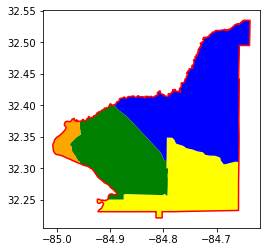

In [333]:
ax = vest_ga_20[vest_ga_20["CTYNAME"]=="CHATTAHOOCHEE"].boundary.plot(color="red")
ga_shapefile[ga_shapefile["CTYNAME"]=="CHATTAHOOCHEE"].plot(ax = ax,color="yellow")
ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN1"].plot(ax = ax,color="blue")
ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN2"].plot(ax = ax,color="green")
ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN3"].plot(ax = ax,color="orange")

#### Merge the four VTDS and plot the result

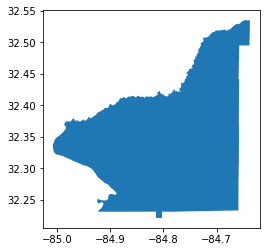

In [335]:
index_fort_1 = ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN1"].index.values[0]
index_fort_2 = ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN2"].index.values[0]
index_fort_3 = ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN3"].index.values[0]

prec2combine = [ga_shapefile.loc[ga_shapefile["PRECINCT_N"]=="ACTIVITY CENTER"],ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN1"],ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN2"],ga_shapefile[ga_shapefile["DISTRICT"]=="053FTBEN3"]]
new_fort = gp.GeoDataFrame(pd.concat(prec2combine, ignore_index=True), crs = ga_shapefile.crs)

ga_shapefile.loc[ga_shapefile["PRECINCT_N"]=="ACTIVITY CENTER","geometry"]=new_fort.unary_union
ga_shapefile.loc[ga_shapefile["PRECINCT_N"]=="ACTIVITY CENTER","unique_ID"]="053-ACTIVITY CENTER (Includes FTBEN 1-3)"
ga_shapefile.loc[ga_shapefile["unique_ID"]=="053-ACTIVITY CENTER (Includes FTBEN 1-3)"].plot()
ga_shapefile = ga_shapefile.drop([index_fort_1,index_fort_2,index_fort_3])
ga_shapefile.reset_index(drop=True, inplace=True)

### Barrow: Merge 2/15, 3/12, 4/14, 5/7, 6/10/13, 8/9, 11/16; Adjust new 2/13 boundary - Partially Completed
All of the merges seem to have already been completed, VEST doesn't provide much detail on the 2/13 boundary adjustment, but it's reasonable to assume that that's also been performed, as the others have been. Any differences will be plotted in the shapefile validation.

In [340]:
ga_shapefile[ga_shapefile["CTYNAME"]=="BARROW"][["PRECINCT_N"]]

,PRECINCT_N
1793,03
1794,04
2196,02
2234,05
2239,13
2240,08
2241,16
2243,01


### Bartow: Split Cassville/Hamilton Crossing - Completed
This seems to have been performed already in the shapefile.

In [342]:
ga_shapefile[(ga_shapefile["CTYNAME"]=="BARTOW") & (ga_shapefile["PRECINCT_N"].isin(["CASSVILLE","HAMILTON CROSSING"]))][["PRECINCT_N"]]

,PRECINCT_N
2085,HAMILTON CROSSING
2086,CASSVILLE


#### Candler: Merge Candler/Metter as Jack Strickland Comm Center - Completed
This seems to have been performed already in the shapefile as this is the only precinct in Candler.

In [345]:
ga_shapefile[ga_shapefile["CTYNAME"]=="CANDLER"][["PRECINCT_N"]]

,PRECINCT_N
1328,JACK STRICKLAND COMMUNITY CENTER


#### Chatham: Split 7-7/8-16, 7-12/7-16; Realign 7-06C/7-07C -  Partially Completed
All of the splits seem to have already been completed, VEST doesn't provide much detail on the realignment, but it's reasonable to assume that that's also been performed, as the others have been. Any differences will be plotted in the shapefile validation.

In [346]:
ga_shapefile[(ga_shapefile["CTYNAME"]=="CHATHAM") & (ga_shapefile["PRECINCT_I"].str[0:4].isin(["7-07","8-16","7-12","7-16"]))]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
1659,0517-16C,0517-16C,7-16C,POOLER RECREATION CENTER GYMNASIUM,CHATHAM,025,051,"POLYGON ((-81.30470 32.09313, -81.30247 32.092...",051-POOLER RECREATION CENTER GYMNASIUM
1660,0517-12C,0517-12C,7-12C,POOLER RECREATION CENTER GYMNASIUM,CHATHAM,025,051,"MULTIPOLYGON (((-81.24078 32.08290, -81.24100 ...",051-POOLER RECREATION CENTER GYMNASIUM
1680,0517-07C,0517-07C,7-07C,ROTHWELL BAPTIST CHURCH,CHATHAM,025,051,"POLYGON ((-81.26321 32.12098, -81.26681 32.122...",051-ROTHWELL BAPTIST CHURCH
1681,0518-16C,0518-16C,8-16C,MIGHTY EIGHTH MUSEUM,CHATHAM,025,051,"POLYGON ((-81.28350 32.16288, -81.28333 32.165...",051-MIGHTY EIGHTH MUSEUM


#### Chatooga: Split Cloudland/Teloga along ridgeline that marks boundary between them with the USGS Topographic Contour shapefile - Not Completed

<AxesSubplot:>

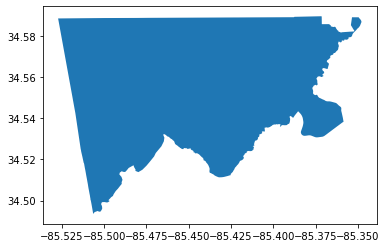

In [79]:
ga_shapefile[ga_shapefile["PRECINCT_N"]=="CLOUDLAND-TELOGA"].plot()

#### Clayton: Split Ellenswood 1/2, Jonesboro 1/17/19, Lovejoy 3/6/7, Morrow 3/11, 5/10, Oak 3/5 - Completed
These changes appear to have been performed already

In [347]:
precinct_list = ["ELLENWOOD 1","ELLENWOOD 2","JONESBORO 1","JONESBORO 17","JONESBORO 19",
                "LOVEJOY 3","LOVEJOY 6", "LOVEJOY 7", "MORROW 3","MORROW 11","MORROW 5", "MORROW 10", "OAK 3", "OAK 5"]

ga_shapefile[(ga_shapefile["CTYNAME"]=="CLAYTON")&(ga_shapefile["PRECINCT_N"].isin(precinct_list))][["PRECINCT_N"]]

,PRECINCT_N
547,LOVEJOY 7
560,MORROW 5
561,MORROW 10
580,OAK 3
617,LOVEJOY 3
620,JONESBORO 19
621,JONESBORO 17
650,JONESBORO 1
1127,LOVEJOY 6
2051,ELLENWOOD 2


#### Cobb: Split Bells Ferry 3/4, Dobbins 1/2, Marietta 3A/3B, Smyrna 3A/3B - Not Completed

In [350]:
precinct_list = ["BELLS FERRY 03","BELLS FERRY 04","DOBBINS 01","DOBBINS 02",
                "SMYRNA 3A","SMYRNA 3B", "MARIETTA 3A", "MARIETTA 3B"]

ga_shapefile[(ga_shapefile["CTYNAME"]=="COBB")&(ga_shapefile["PRECINCT_N"].isin(precinct_list))]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
172,067F03,067F03,F03,BELLS FERRY 03,COBB,033,067,"POLYGON ((-84.57168 34.07630, -84.57147 34.076...",067-BELLS FERRY 03
181,067I01,067I01,I01,DOBBINS 01,COBB,033,067,"MULTIPOLYGON (((-84.48767 33.91140, -84.48755 ...",067-DOBBINS 01
221,067R3A,067R3A,R3A,MARIETTA 3A,COBB,033,067,"POLYGON ((-84.58508 33.95008, -84.58416 33.950...",067-MARIETTA 3A
272,067N3A,067N3A,N3A,SMYRNA 3A,COBB,033,067,"MULTIPOLYGON (((-84.51435 33.89332, -84.51433 ...",067-SMYRNA 3A


#### Columbia: Split Bessie Thomas/2nd Mt Moriah, Harlem Branch/Harlem Senior Ctr; Merge Blanchard Park/MTZ Col FD;  Align multiple precincts with county maps

In [82]:
BESSIE THOMAS CENTER   
SECOND MOUNT MORIAH BAPTIST CHURCH   
HARLEM SENIOR CENTER   

HARLEM BRANCH LIBRARY

BLANCHARD PARK
MTZ COL FIRE HDQTR.

print(ga_shapefile[ga_shapefile["CTYNAME"]=="COLUMBIA"])

     DISTRICT CTYSOSID PRECINCT_I                                  PRECINCT_N  \
487    073131   073131        131                        JOURNEY COMM. CHURCH   
488    073064   073064        064                        GRACE BAPTIST CHURCH   
489    073061   073061        061                             GREENBRIER HIGH   
490    073063   073063        063                            RIVERVIEW CHURCH   
491    073132   073132        132                            WESLEY METHODIST   
492    073135   073135        135                 CHRIST CHURCH, PRESBYTERIAN   
493    073107   073107        107                         GOSPEL WATER BRANCH   
494    073040   073040        040                        EUBANK/BLANCHARD CTR   
693    073109   073109        109                        STEVENS CREEK CHURCH   
702    073111   073111        111                             LAKESIDE MIDDLE   
703    073136   073136        136                        BLUERIDGE ELEMENTARY   
704    073137   073137      

#### Coweta: Merge Arts Centre/Jefferson Parkway as Newnan Centre

In [83]:
ga_shapefile[ga_shapefile["PRECINCT_N"]=="THE NEWNAN CENTRE"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
1140,07718,07718,18,THE NEWNAN CENTRE,COWETA,038,077,"POLYGON ((-84.68711 33.36559, -84.68728 33.365...",077-THE NEWNAN CENTRE


In [362]:
ga_shapefile[ga_shapefile["CTYNAME"]=="COWETA"]["PRECINCT_N"].unique()

array(['DRESDEN', 'CEDAR CREEK', 'MADRAS', 'CENTRAL', 'GREENTOP',
       'WELCOME', 'SMOKEY ROAD', 'WESTSIDE', 'NEWNAN', 'EXPO CENTER',
       'PANTHER CREEK', 'MORELAND', 'PINE ROAD', 'GRANTVILLE',
       'COWETA CENTRAL LIBRARY', 'THOMAS CROSSROADS', 'TURIN', 'HARALSON',
       'SENOIA', 'SHARPSBURG', 'FISCHER ROAD', 'CANNONGATE', 'RAYMOND',
       'THE NEWNAN CENTRE', 'WHITE OAK', 'NORTHSIDE'], dtype=object)

#### Fulton: Merge CP07A/CP07D, CH01/CH04B, SS29A/SS29B, UC031/UC035

In [84]:
precinct_list = ["121CP07A","121CP07D","121CH01","121CH04B",
                "121SS29A","121SS29B", "121UC031", "121UC035"]

ga_shapefile[(ga_shapefile["DISTRICT"].isin(precinct_list))]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
537,121CH04B,None,None,None,None,None,None,"POLYGON ((-84.66472 33.54058, -84.66442 33.540...",121-CH04B
608,121UC031,121UC031,UC031,UC031,FULTON,060,121,"POLYGON ((-84.51855 33.59117, -84.51853 33.592...",121-UC031
611,121UC035,None,None,None,None,None,None,"MULTIPOLYGON (((-84.50786 33.58318, -84.50733 ...",121-UC035
628,121CH01,121CH01,CH01,CH01,FULTON,060,121,"MULTIPOLYGON (((-84.66985 33.54568, -84.66988 ...",121-CH01
2108,121SS29B,None,None,None,None,None,None,"POLYGON ((-84.34772 33.96030, -84.34804 33.960...",121-SS29B
2337,121CP07A,None,None,None,None,None,None,"POLYGON ((-84.48674 33.64957, -84.48684 33.651...",121-CP07A
2367,121CP07D,121CP07D,CP07D,CP07D,FULTON,060,121,"POLYGON ((-84.47553 33.64713, -84.47562 33.647...",121-CP07D
2414,121SS29A,121SS29A,SS29A,SS29A,FULTON,060,121,"POLYGON ((-84.34782 33.94024, -84.34782 33.939...",121-SS29A


#### DeKalb: Split Clarkston/Clarkston Comm Ctr; Realign Decatur/Oakhurst; Align precincts with Atlanta, Brookhaven, Decatur, Tucker city limits 
Not enough info given here to recreate

In [85]:
"CLARKSTON"
print(ga_shapefile[(ga_shapefile["CTYNAME"]=="DEKALB") & (ga_shapefile["PRECINCT_N"].str[0:1]=="C")])

    DISTRICT CTYSOSID PRECINCT_I                      PRECINCT_N CTYNAME  \
306   0890CP   0890CP        0CP                      CROSSROADS  DEKALB   
310   0890CM   0890CM        0CM                 COLUMBIA MIDDLE  DEKALB   
320   0890CW   0890CW        0CW                       CORALWOOD  DEKALB   
330   0890CR   0890CR        0CR              CEDAR GROVE MIDDLE  DEKALB   
337   0890CA   0890CA        0CA                  COLUMBIA DRIVE  DEKALB   
341   0890CB   0890CB        0CB                 CANBY LANE ELEM  DEKALB   
343   0890CC   0890CC        0CC                   COLUMBIA ELEM  DEKALB   
346   0890CD   0890CD        0CD                CEDAR GROVE ELEM  DEKALB   
347   0890CE   0890CE        0CE                  CHAMBLEE (CHA)  DEKALB   
348   0890CF   0890CF        0CF  CANDLER - MURPHEY CANDLER ELEM  DEKALB   
351   0890CG   0890CG        0CG                CHAPEL HILL ELEM  DEKALB   
353   0890CH   0890CH        0CH              CHESNUT ELEM (DUN)  DEKALB   
355   0890CI

#### Gwinnett: Adjust Baycreek F/G, Berkshire J/M, Cates D/F, Garners C/B, Lawrenceville G/N, Pinckneyville S/T, Rockbridge A/G
There isn't enough detail to check these changes.

#### Lowndes: Split Northgate Assembly/Trinity, Jaycee/Mt Calvary/Northside/VSU

In [86]:
ga_shapefile[ga_shapefile["CTYNAME"]=="LOWNDES"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
1256,185012,185012,012,NORTHGATE ASSEMBLY,LOWNDES,092,185,"POLYGON ((-83.24813 30.99291, -83.24826 30.993...",185-NORTHGATE ASSEMBLY
1264,185007,185007,007,CLYATTVILLE,LOWNDES,092,185,"POLYGON ((-83.45643 30.78682, -83.45589 30.787...",185-CLYATTVILLE
1295,185009,185009,009,S LOWNDES,LOWNDES,092,185,"POLYGON ((-83.13575 30.64111, -83.13662 30.625...",185-S LOWNDES
1296,185008,185008,008,DASHER,LOWNDES,092,185,"POLYGON ((-83.13527 30.76853, -83.13516 30.768...",185-DASHER
1297,185004,185004,004,NAYLOR,LOWNDES,092,185,"POLYGON ((-83.09403 30.83124, -83.10323 30.831...",185-NAYLOR
1299,185001,185001,001,HAHIRA TRAIN DEPOT,LOWNDES,092,185,"POLYGON ((-83.26666 31.02672, -83.26194 31.026...",185-HAHIRA TRAIN DEPOT
1303,185006,185006,006,MILDRED,LOWNDES,092,185,"POLYGON ((-83.28026 30.83020, -83.27995 30.830...",185-MILDRED
1304,185013,185013,013,MT CALVARY,LOWNDES,092,185,"POLYGON ((-83.23113 30.87883, -83.23096 30.878...",185-MT CALVARY
1305,185011,185011,011,JAYCEE SHACK,LOWNDES,092,185,"POLYGON ((-83.25038 30.88168, -83.25047 30.881...",185-JAYCEE SHACK
1306,185002,185002,002,TRINITY,LOWNDES,092,185,"POLYGON ((-83.26498 30.97960, -83.26484 30.979...",185-TRINITY


#### Oconee: Merge Annex/City Hall; Align City Hall with Watkinsville city limits

In [87]:
ga_shapefile[ga_shapefile["CTYNAME"]=="OCONEE"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
507,21903,21903,03,ANTIOCH,OCONEE,108,219,"POLYGON ((-83.35190 33.71521, -83.35708 33.713...",219-ANTIOCH
508,21902,21902,02,COLHAM FERRY,OCONEE,108,219,"POLYGON ((-83.32129 33.85460, -83.32045 33.854...",219-COLHAM FERRY
2554,21905,21905,05,BISHOP,OCONEE,108,219,"POLYGON ((-83.47579 33.79612, -83.47570 33.796...",219-BISHOP
2555,21912,21912,12,CIVIC CENTER,OCONEE,108,219,"POLYGON ((-83.43578 33.84933, -83.43586 33.849...",219-CIVIC CENTER
2556,21910,21910,10,MARSWOOD HALL,OCONEE,108,219,"POLYGON ((-83.47009 33.93095, -83.46996 33.931...",219-MARSWOOD HALL
2558,21901,21901,01,CITY HALL,OCONEE,108,219,"POLYGON ((-83.35806 33.87485, -83.35699 33.874...",219-CITY HALL
2564,21904,21904,04,FARMINGTON,OCONEE,108,219,"POLYGON ((-83.39124 33.70294, -83.39522 33.701...",219-FARMINGTON
2582,21911,21911,11,EAST OCONEE,OCONEE,108,219,"POLYGON ((-83.40174 33.91087, -83.40144 33.910...",219-EAST OCONEE
2613,21908,21908,08,DARK CORNER,OCONEE,108,219,"POLYGON ((-83.64585 33.90685, -83.64434 33.907...",219-DARK CORNER
2614,21906,21906,06,HIGH SHOALS,OCONEE,108,219,"POLYGON ((-83.50223 33.81723, -83.50240 33.817...",219-HIGH SHOALS


#### Paulding: Reorganize 12 precincts into 19 precincts as redrawn in 2019

In [88]:
ga_shapefile[ga_shapefile["CTYNAME"]=="PAULDING"].shape

(19, 9)

#### Randolph: Merge Carnegie/Cuthbert-Courthouse, 4th District/Fountain Bridge/Shellman

In [89]:
ga_shapefile[ga_shapefile["CTYNAME"]=="RANDOLPH"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
643,243131,243131,131,COLEMAN,RANDOLPH,120,243,"POLYGON ((-84.92013 31.61864, -84.92276 31.618...",243-COLEMAN
885,243334,243334,334,SHELLMAN,RANDOLPH,120,243,"POLYGON ((-84.66683 31.62006, -84.66747 31.620...",243-SHELLMAN
889,243954,243954,954,SPRINGVALE,RANDOLPH,120,243,"POLYGON ((-84.95864 31.77755, -84.95864 31.777...",243-SPRINGVALE
890,243718B,243718B,718B,CUTHBERT,RANDOLPH,120,243,"POLYGON ((-84.79549 31.76895, -84.79536 31.768...",243-CUTHBERT
891,243566,243566,566,BENEVOLENCE,RANDOLPH,120,243,"POLYGON ((-84.68127 31.77297, -84.68336 31.772...",243-BENEVOLENCE
895,243718A,243718A,718A,CUTHBERT/COURTHOUSE,RANDOLPH,120,243,"POLYGON ((-84.70139 31.61988, -84.70780 31.619...",243-CUTHBERT/COURTHOUSE


#### Troup: Split Mountville between Gardner Newman/Hogansville/Rosemont; Align multiple precincts with county maps

In [90]:
ga_shapefile[ga_shapefile["CTYNAME"]=="TROUP"]

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
619,28515,28515,15,HIGHLAND,TROUP,141,285,"POLYGON ((-85.02925 33.00490, -85.02920 33.006...",285-HIGHLAND
633,28512,28512,12,GARDNER NEWMAN,TROUP,141,285,"POLYGON ((-84.91251 33.04024, -84.91246 33.039...",285-GARDNER NEWMAN
971,28505,28505,05,WEST POINT,TROUP,141,285,"POLYGON ((-85.17470 32.87050, -85.17486 32.870...",285-WEST POINT
973,28511,28511,11,LONG CANE,TROUP,141,285,"POLYGON ((-85.07493 32.96765, -85.07468 32.967...",285-LONG CANE
974,28513,28513,13,GRAY HILL,TROUP,141,285,"POLYGON ((-85.09944 32.86951, -85.09941 32.866...",285-GRAY HILL
1009,28502,28502,02,ADMINISTRATION BLDG,TROUP,141,285,"POLYGON ((-85.03674 33.03872, -85.03654 33.038...",285-ADMINISTRATION BLDG
1010,28504,28504,04,GRIGGS CENTER,TROUP,141,285,"POLYGON ((-85.03205 33.03874, -85.03114 33.038...",285-GRIGGS CENTER
1011,28508,28508,08,ROSEMONT,TROUP,141,285,"POLYGON ((-84.94925 32.86899, -84.96499 32.869...",285-ROSEMONT
1021,28516,28516,16,NORTHSIDE,TROUP,141,285,"POLYGON ((-85.07638 33.07814, -85.07666 33.078...",285-NORTHSIDE
1023,28503,28503,03,HAMMETT RD,TROUP,141,285,"POLYGON ((-85.00387 33.04356, -85.00433 33.043...",285-HAMMETT RD


### Towns: Merge Macedonia/Tate City - Completed

In [363]:
ga_shapefile[ga_shapefile["CTYNAME"]=="TOWNS"]["PRECINCT_N"].unique()

array(['YOUNG HARRIS', 'HIAWASSEE', 'MACEDONIA'], dtype=object)

In [92]:
join_attempt_3 = pd.merge(ga_election,ga_shapefile,how="outer",on="unique_ID",indicator=True)
print(join_attempt_3["_merge"].value_counts())

left_only = join_attempt_3[join_attempt_3["_merge"]=="left_only"]
right_only = join_attempt_3[join_attempt_3["_merge"]=="right_only"]

left_only.to_csv("./source_join_elections.csv")
right_only.to_csv("./source_join_shapes.csv")

both          2379
left_only      300
right_only     297
Name: _merge, dtype: int64


In [93]:
example_csv = pd.read_csv("./shp_id_changes.csv")
example_fips_dict = dict(zip(example_csv["shp_ID"],example_csv["election_ID"]))

ga_shapefile["unique_ID"] = ga_shapefile["unique_ID"].map(example_fips_dict).fillna(ga_shapefile["unique_ID"])

In [94]:
ga_shapefile.loc[ga_shapefile["CTYSOSID"]=="0513-15C","unique_ID"] = "051-ELI WHITNEY COMPLEX 3-15C"
ga_shapefile.loc[ga_shapefile["CTYSOSID"]=="0512-06C","unique_ID"] = "051-ELI WHITNEY COMPLEX 2-06C"

In [95]:
join_attempt_3 = pd.merge(ga_election,ga_shapefile,how="outer",on="unique_ID",indicator=True)
print(join_attempt_3["_merge"].value_counts())

left_only = join_attempt_3[join_attempt_3["_merge"]=="left_only"]
right_only = join_attempt_3[join_attempt_3["_merge"]=="right_only"]

ga_source = join_attempt_3[join_attempt_3["_merge"]=="both"]

left_only.to_csv("./source_join_elections.csv")
right_only.to_csv("./source_join_shapes.csv")

both          2670
left_only       10
right_only       6
Name: _merge, dtype: int64


In [96]:
left_only_list = list(left_only["unique_ID"])
print(ga_election[ga_election["unique_ID"].isin(left_only_list)]["unique_ID"])

303                 051-POOLER CHURCH
324                     055-CLOUDLAND
334                        055-TELOGA
485                067-BELLS FERRY 04
504                    067-DOBBINS 02
552                   067-MARIETTA 3B
603                     067-SMYRNA 3B
793    089-CLARKSTON COMMUNITY CENTER
804                       089-DECATUR
951                         121-CP053
Name: unique_ID, dtype: object


In [97]:
right_only_list = list(right_only["unique_ID"])
print(ga_shapefile[(ga_shapefile["unique_ID"].isin(right_only_list))&(ga_shapefile["unique_ID"].str[0:3]!="121")]["unique_ID"])
print(ga_shapefile[(ga_shapefile["unique_ID"].isin(right_only_list))&(ga_shapefile["unique_ID"].str[0:3]=="121")]["unique_ID"])

379     089-RENFROE MIDDLE (DEC)
1981        055-CLOUDLAND-TELOGA
Name: unique_ID, dtype: object
537     121-CH04B
611     121-UC035
2108    121-SS29B
2337    121-CP07A
Name: unique_ID, dtype: object


1747897.0050948313

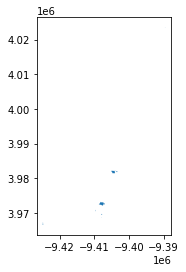

In [98]:
fulton_remaining = ga_shapefile[(ga_shapefile["unique_ID"].isin(right_only_list))&(ga_shapefile["unique_ID"].str[0:3]=="121")]
fulton_remaining = fulton_remaining.to_crs(3857)
fulton_remaining.plot()
sum(fulton_remaining.area)

In [99]:
ga_shapefile

,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNAME,CTYNUMBER2,FIPS2,geometry,unique_ID
0,135001,135001,001,HARBINS A,GWINNETT,067,135,"POLYGON ((-83.92720 33.95932, -83.92718 33.959...",135-HARBINS A
1,135002,135002,002,ROCKBRIDGE A,GWINNETT,067,135,"POLYGON ((-84.07069 33.80553, -84.06961 33.805...",135-ROCKBRIDGE A
2,135003,135003,003,DACULA,GWINNETT,067,135,"POLYGON ((-83.93919 33.97860, -83.93773 33.979...",135-DACULA
3,135004,135004,004,SUWANEE A,GWINNETT,067,135,"POLYGON ((-84.09215 34.04908, -84.09206 34.049...",135-SUWANEE A
4,135028,135028,028,ROCKYCREEK A,GWINNETT,067,135,"POLYGON ((-83.91067 34.01586, -83.91052 34.016...",135-ROCKYCREEK A
...,...,...,...,...,...,...,...,...,...
2671,11735,11735,35,35 JOHNS CREEK,FORSYTH,058,117,"POLYGON ((-84.14664 34.05659, -84.14759 34.057...",117-35 JOHNS CREEK
2672,11719,11719,19,19 OLD ATLANTA,FORSYTH,058,117,"POLYGON ((-84.13691 34.10059, -84.13570 34.101...",117-19 OLD ATLANTA
2673,11721,11721,21,21 SOUTH FORSYTH,FORSYTH,058,117,"POLYGON ((-84.17506 34.11764, -84.17503 34.117...",117-21 SOUTH FORSYTH
2674,11736,11736,36,36 NICHOLS,FORSYTH,058,117,"POLYGON ((-84.13570 34.10106, -84.13691 34.100...",117-36 NICHOLS


In [100]:
final_merge = pd.merge(ga_source,vest_ga_20,how="outer",on="unique_ID",indicator="final_merge")

print(final_merge["final_merge"].value_counts())

both          2670
right_only      10
left_only        0
Name: final_merge, dtype: int64


In [101]:
vest_only_list = list(final_merge[final_merge["final_merge"]=="right_only"]["unique_ID"])
vest_ga_20[vest_ga_20["unique_ID"].isin(vest_only_list)]["unique_ID"]

951                          121-CP053
1871                     055-CLOUDLAND
1881                        055-TELOGA
1896                 051-POOLER CHURCH
2090                       089-DECATUR
2093    089-CLARKSTON COMMUNITY CENTER
2655                067-BELLS FERRY 04
2656                    067-DOBBINS 02
2659                   067-MARIETTA 3B
2660                     067-SMYRNA 3B
Name: unique_ID, dtype: object

121-CP053
055-CLOUDLAND
055-TELOGA
051-POOLER CHURCH
089-DECATUR
089-CLARKSTON COMMUNITY CENTER
067-BELLS FERRY 04
067-DOBBINS 02
067-MARIETTA 3B
067-SMYRNA 3B


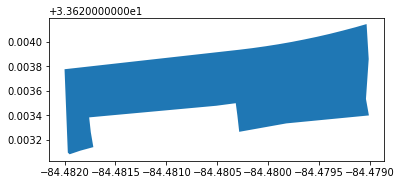

In [102]:
for i in vest_only_list:
    print(i)
    if i[0:3]=="121":
        vest_ga_20[vest_ga_20["unique_ID"]==i].plot()

089-RENFROE MIDDLE (DEC)
055-CLOUDLAND-TELOGA


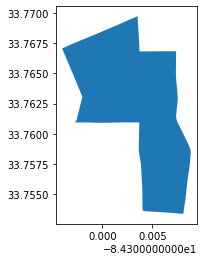

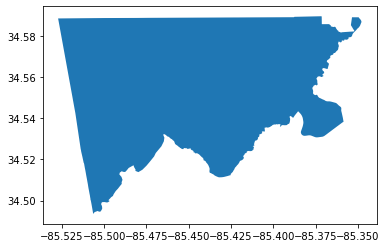

In [103]:
right_only_list = list(right_only["unique_ID"])

for i in right_only_list:
    if i[0]!="1":
        print(i)
        ga_shapefile[ga_shapefile["unique_ID"]==i].plot()

In [104]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_ga_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_ga_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

False    2190
True      480
dtype: int64


1) For 021-HAZZARD 4 difference in area is 3.3706615343443707
2) For 021-HOWARD 1 difference in area is 5.036147171439918
3) For 021-HOWARD 2 difference in area is 2.5699095162291674
4) For 021-HOWARD 3 difference in area is 1.5699552273580146
5) For 021-HOWARD 5 difference in area is 0.5171174601516663
6) For 051-LAKE SHORE COMM CTR difference in area is 1.8155223560836502
7) For 051-RICE CREEK SCHOOL difference in area is 1.8110601544647957
8) For 051-POOLER REC CENTER GYM difference in area is 3.5429986118187844
9) For 067-BELLS FERRY 03 difference in area is 0.7435728376865838
10) For 067-DOBBINS 01 difference in area is 0.5291437226811758
11) For 073-PARKWAY BAPTIST CHURCH difference in area is 0.5694240817096237
12) For 073-PATRIOTS PARK difference in area is 0.859698204711429
Not able to run code for:  089-GLENNWOOD
13) For 223-BEULAHLAND BAPTIST CHURCH difference in area is 1.9718280831816215
14) For 223-WATSON GOVT CMPLX difference in area is 2.2743294610128006
15) For 285-LON

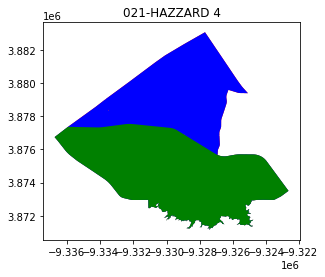

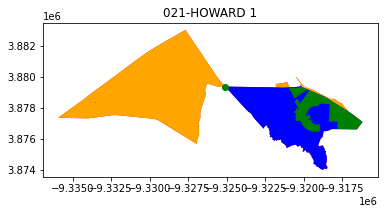

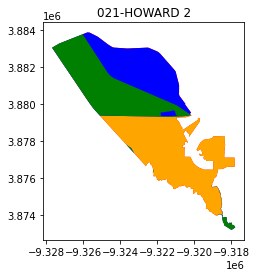

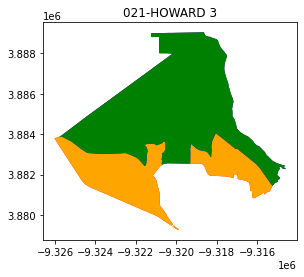

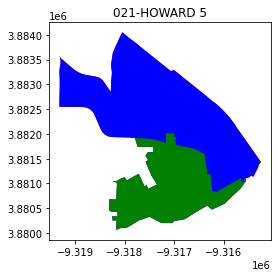

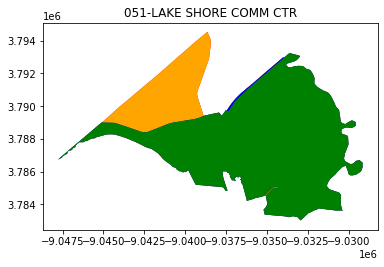

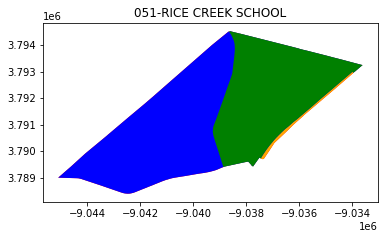

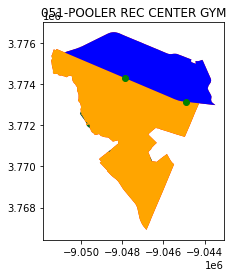

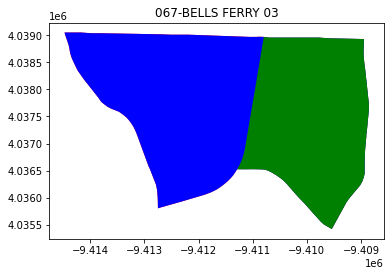

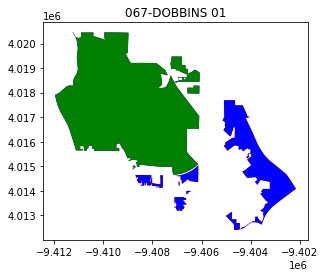

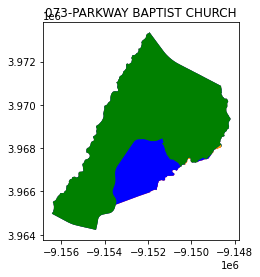

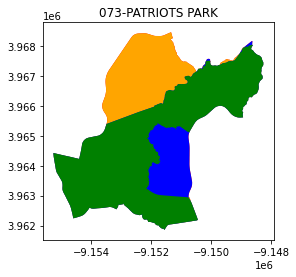

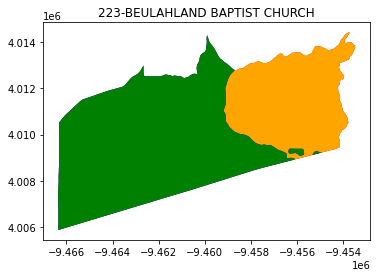

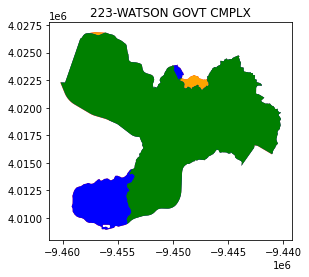

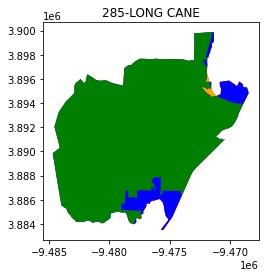

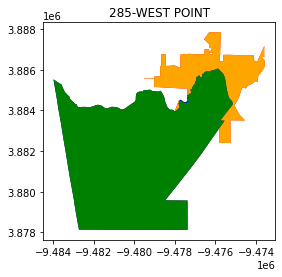

In [105]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    try:
        diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
        intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
        area = float(diff.area/10e6)
        area_list.append(area)
            #print("Area is " + str(area))

        if (area > .5):
            count += 1
            name = source_geoms.iat[i,0]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = diff.plot(color="red")
                source_geoms.iloc[[i]].plot(color="orange",ax=base)
                vest_geoms.iloc[[i]].plot(color="blue",ax=base)
                base.set_title(name)
            else:
                base = diff.plot(color="red")
                source_geoms.iloc[[i]].plot(color="orange",ax=base)
                vest_geoms.iloc[[i]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
    except:
        print("Not able to run code for: ", source_geoms.iat[i,0])
        #diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])


In [106]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(2669, 1)
1638 precincts w/ a difference of 0 km^2
979 precincts w/ a difference between 0 and .1 km^2
36 precincts w/ a difference between .1 and .5 km^2
6 precincts w/ a difference between .5 and 1 km^2
5 precincts w/ a difference between 1 and 2 km^2
4 precincts w/ a difference between 2 and 5 km^2
1 precincts w/ a difference greater than 5 km^2
